In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## non-official implementation, purpose is to see inner workings of DICE model

## Helpers

In [2]:
class DICEModel:
    def __init__(self):
        # Time parameters
        self.start_year = 2020
        self.end_year = 2120
        self.time_step = 5
        self.n_steps = (self.end_year - self.start_year) // self.time_step + 1
    
        # Labor/Population parameters
        self.labor_0 = 7.7      # Initial labor force (billions)
        self.labor_growth = 0.035  # Initial labor force growth rate
        
        # Economic parameters
        self.tfp_0 = 5.115    # Initial total factor productivity
        self.tfp_growth = 0.016  # TFP growth rate
        self.alpha = 0.3      # Capital share
        self.delta = 0.1      # Depreciation rate
        self.savings = 0.2    # Savings rate

        # Initialize arrays for time series
        self.years = np.arange(self.start_year, self.end_year + self.time_step, self.time_step)
        self.labor = np.zeros(self.n_steps)
        self.capital = np.zeros(self.n_steps)
        self.tfp = np.zeros(self.n_steps)
        
        # Set initial values
        self.labor[0] = self.labor_0
        self.capital[0] = 80  # Initial capital stock (trillion $)
        self.tfp[0] = self.tfp_0

        # Emissions parameters
        self.sigma_0 = 0.35        # Initial carbon intensity (GtC per trillion $)
        self.sigma_growth = -0.01  # Rate of decline in carbon intensity
        self.mu_0 = 0.03          # Initial emissions control rate

        # Emissions-related arrays
        self.sigma = np.zeros(self.n_steps)      # Carbon intensity
        self.mu = np.zeros(self.n_steps)         # Emissions control rate
        self.emissions = np.zeros(self.n_steps)   # Industrial emissions
        self.cum_emissions = np.zeros(self.n_steps)  # Cumulative emissions

        # Set initial values
        self.sigma[0] = self.sigma_0
        self.mu[0] = self.mu_0

        # Climate system parameters
        self.climate_sensitivity = 3.0    # Climate sensitivity (°C per CO2 doubling)
        self.forcing_coefficient = 3.8    # Forcing coefficient (W/m² per CO2 doubling)
        self.heat_capacity = 0.22        # Ocean heat capacity coefficient
        self.pre_industrial_co2 = 280    # Pre-industrial CO2 (ppm)
        self.initial_temperature = 0.85   # Initial temperature rise (°C)

        # Initialize climate arrays
        self.temperature = np.zeros(self.n_steps)  # Temperature change (°C)
        self.co2_concentration = np.zeros(self.n_steps)  # Atmospheric CO2 (ppm)
        
        # Set initial values with realistic 2020 CO2 concentration
        self.temperature[0] = self.initial_temperature
        self.co2_concentration[0] = 415  # 2020 CO2 concentration in ppm

        # Damage function parameters
        self.damage_coefficient = 0.00267  # Standard DICE parameter
        self.damage_exponent = 2           # Quadratic damage function
        self.adaptation_cost = 0.0         # We can add this later

        self.adaptation_efficiency = 0.3    # How effective adaptation spending is  
        self.max_adaptation = 0.5          # Maximum possible damage reduction
        self.adaptation_cost_coefficient = 0.1  # Cost of adaptation as fraction of output

        self.raw_damages = np.zeros(self.n_steps)
        self.adaptation_spending = np.zeros(self.n_steps)
        self.net_damages = np.zeros(self.n_steps)

        # Carbon pricing parameters
        self.initial_carbon_price = 30    # Initial price per ton of CO2 ($)
        self.carbon_price_growth = 0.02   # Annual growth rate of carbon price
        self.carbon_prices = np.zeros(self.n_steps)  # Array to store prices
        self.carbon_revenues = np.zeros(self.n_steps)  # Array to store revenues

        self.min_climate_sensitivity = 1.5  # Minimum (°C per CO2 doubling)
        self.max_climate_sensitivity = 8.0  # Maximum (°C per CO2 doubling)

        # Parameters for carbon cycle
        self.airborne_fraction = 0.45    # Fraction of emissions staying in atmosphere
        self.carbon_decay = 0.005        # Natural carbon absorption rate

    def production_function(self, time_period):
        """Calculate economic output using Cobb-Douglas production function
        Y = A × K^α × L^(1-α)  with damage feedback"""

        base_output = self.tfp[time_period] * \
                    (self.capital[time_period]**self.alpha) * \
                    (self.labor[time_period]**(1 - self.alpha))
        # Reduce output by damage fraction
        damage_fraction = self.calculate_damages(self.temperature[time_period])
        return base_output * (1 - damage_fraction)

    def calculate_labor_growth(self):
        for t in range(1, self.n_steps):
            # Labor grows at declining rate
            growth_rate = self.labor_growth * np.exp(-0.05 * t)
            self.labor[t] = self.labor[t-1] * (1 + growth_rate)

    def calculate_tfp_growth(self):
        for t in range(1, self.n_steps):
            # TFP grows at declining rate
            self.tfp[t] = self.tfp[t-1] * (1 + self.tfp_growth)

    def calculate_capital_growth(self):
        for t in range(1, self.n_steps):
            # Capital accumulation with depreciation
            investment = self.savings * self.production_function(t-1)
            self.capital[t] = self.capital[t-1] * (1 - self.delta) + investment

    def calculate_carbon_intensity(self):
        """Calculate how carbon intensity (sigma) changes over time
        Carbon intensity typically decreases due to technological improvements"""
        for t in range(1, self.n_steps):
            # Carbon intensity declines at an exponentially decreasing rate
            self.sigma[t] = self.sigma[t-1] * (1 + self.sigma_growth)

    def calculate_emission_control(self, time_period):
        """Calculate optimal emission control rate based on carbon price"""
        
        # Get carbon price for this period
        carbon_price = self.carbon_prices[time_period]
        
        # Increase MAC coefficient to make abatement more expensive
        mac_coefficient = 0.5  # Increased from 0.05
        
        # Add a maximum control rate to represent technological limits
        max_control_rate = 0.8  # Maximum possible emission reduction
        
        # Calculate optimal control rate with more realistic constraints
        control_rate = min(max_control_rate, 
                        carbon_price / (mac_coefficient * self.production_function(time_period)))
        
        return max(0.0, min(control_rate, max_control_rate))

    def calculate_emissions(self, time_period):
        """Calculate industrial CO2 emissions
        E = σ * Y * (1 - μ)
        where:
        - σ (sigma) is carbon intensity
        - Y is output
        - μ (mu) is emissions control rate from carbon pricing
        """
        output = self.production_function(time_period)
        control_rate = self.calculate_emission_control(time_period)
        emissions = self.sigma[time_period] * output * (1 - control_rate)
        return emissions

    def calculate_emissions_path(self):
        """Calculate emissions for all time periods"""
        # First calculate carbon prices over time
        for t in range(self.n_steps):
            # Carbon price grows at specified rate
            self.carbon_prices[t] = self.initial_carbon_price * \
                                (1 + self.carbon_price_growth)**t
        
        # Then calculate emissions with carbon price effects
        for t in range(self.n_steps):
            self.emissions[t] = self.calculate_emissions(t)
            # Calculate cumulative emissions
            if t == 0:
                self.cum_emissions[t] = self.emissions[t]
            else:
                self.cum_emissions[t] = self.cum_emissions[t-1] + self.emissions[t]

    def calculate_co2_concentration(self):
        """Calculate atmospheric CO2 concentration over time"""
       
        # Calculate concentration for each time period
        for t in range(1, self.n_steps):
            # New emissions contribution
            emission_effect = self.airborne_fraction * self.emissions[t-1]
            
            # Natural absorption of excess CO2
            absorption = self.carbon_decay * (self.co2_concentration[t-1] - self.pre_industrial_co2)
            
            # Update concentration
            self.co2_concentration[t] = self.co2_concentration[t-1] + emission_effect - absorption

    def calculate_temperature(self):
        """Calculate temperature change based on CO2 concentrations"""
        adjustment_rate = 0.1  # Rate at which temperature approaches equilibrium
        
        for t in range(1, self.n_steps):
            # Calculate equilibrium temperature based on CO2 concentration
            log_co2_ratio = np.log2(self.co2_concentration[t] / self.pre_industrial_co2)
            equilibrium_temp = self.climate_sensitivity * log_co2_ratio
            
            # Temperature changes gradually towards equilibrium
            self.temperature[t] = max(  # Ensure temperature doesn't go below zero
                self.temperature[t-1] + 
                adjustment_rate * (equilibrium_temp - self.temperature[t-1]),
                0
            )

    def calculate_damages(self, temperature):
        """Calculate economic damages as fraction of output"""
        damage_fraction = 1 - 1/(1 + self.damage_coefficient * temperature**self.damage_exponent)
        return damage_fraction

    def calculate_optimal_adaptation(self, temperature, output):
        """Calculate optimal adaptation spending given temperature and output
        
        Args:
            temperature: Current temperature increase
            output: Current economic output
        Returns:
            optimal_spending: Amount to spend on adaptation
        """
        # Calculate potential damages without adaptation
        raw_damages = self.calculate_damages(temperature) * output
        
        # Calculate marginal benefit of adaptation spending
        marginal_benefit = self.adaptation_efficiency * raw_damages
        
        # Calculate optimal spending (simplified version)
        optimal_spending = min(
            marginal_benefit / self.adaptation_cost_coefficient,
            self.max_adaptation * output
        )
        
        return optimal_spending

    def calculate_reduced_damages(self, temperature, output, adaptation_spending=None):
        """Calculate damages after adaptation measures
        
        Args:
            temperature: Current temperature increase
            output: Current economic output
            adaptation_spending: Amount spent on adaptation (if None, calculates optimal)
        Returns:
            net_damages: Final damages after adaptation
        """
        # Calculate raw damages first
        raw_damages = self.calculate_damages(temperature) * output
        
        # If adaptation spending not provided, calculate optimal
        if adaptation_spending is None:
            adaptation_spending = self.calculate_optimal_adaptation(temperature, output)
        
        # Calculate damage reduction from adaptation (with diminishing returns)
        damage_reduction = min(
            self.adaptation_efficiency * adaptation_spending,
            self.max_adaptation * raw_damages
        )
        
        # Calculate net damages (raw damages - reduction + adaptation costs)
        net_damages = raw_damages - damage_reduction + adaptation_spending
        
        return net_damages

    def calculate_damage_pathway(self):
        """Calculate damages and adaptation for all time periods"""
        for t in range(self.n_steps):
            output = self.production_function(t)
            temp = self.temperature[t]
            
            # Calculate damages and optimal adaptation
            self.raw_damages[t] = self.calculate_damages(temp) * output
            self.adaptation_spending[t] = self.calculate_optimal_adaptation(temp, output)
            self.net_damages[t] = self.calculate_reduced_damages(temp, output)

    def test_carbon_price_scenarios(self):
        # Define different carbon price scenarios
        scenarios = {
            'Low': {'initial_price': 20, 'growth_rate': 0.01},
            'Medium': {'initial_price': 50, 'growth_rate': 0.02},
            'High': {'initial_price': 100, 'growth_rate': 0.03}
        }
        
        results = {}
        
        for scenario, params in scenarios.items():
            # Store original values
            orig_price = self.initial_carbon_price
            orig_growth = self.carbon_price_growth
            
            # Set new values
            self.initial_carbon_price = params['initial_price']
            self.carbon_price_growth = params['growth_rate']
            
            # Run model
            df = self.run_economy(plot_results=False)
            results[scenario] = {
                'Cumulative_Emissions': df['Cumulative_Emissions'].iloc[-1],
                'Final_Temperature': df['Temperature'].iloc[-1],
                'Carbon_Price_Final': self.carbon_prices[-1]
            }
            
            # Restore original values
            self.initial_carbon_price = orig_price
            self.carbon_price_growth = orig_growth
        
        return pd.DataFrame(results).T

    def run_economy(self, plot_results=True):
        """Run all economic calculations and climate impacts in sequence"""
        # First calculate exogenous growth factors
        self.calculate_labor_growth()
        self.calculate_tfp_growth()
        
        # Then calculate capital growth which depends on production
        self.calculate_capital_growth()
        
        # Calculate emissions-related variables
        self.calculate_carbon_intensity()
        self.calculate_emissions_path()
        
        # Add climate calculations
        self.calculate_co2_concentration()
        self.calculate_temperature()
        
        # Add damage calculations
        self.calculate_damage_pathway()
        
        # Store results in a dataframe
        results = {
            'Year': self.years,
            'Labor': self.labor,
            'Capital': self.capital,
            'TFP': self.tfp,
            'Emissions': self.emissions,
            'Cumulative_Emissions': self.cum_emissions,
            'CO2_Concentration': self.co2_concentration,
            'Temperature': self.temperature,
            'Raw_Damages': self.raw_damages,
            'Adaptation_Spending': self.adaptation_spending,
            'Net_Damages': self.net_damages
        }
        df = pd.DataFrame(results)
        
        if plot_results:
            self.plot_results(df)
        
        return df

    def plot_results(self, df=None):
        """Plot model results including economic, emissions, climate and damage data"""
        if df is None:
            df = self.run_economy(plot_results=False)
        
        # Create four subplots
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 25))
        
        # Economic variables on first subplot
        ax1.plot(df['Year'], df['Labor'], label='Labor')
        ax1.plot(df['Year'], df['Capital'], label='Capital')
        ax1.plot(df['Year'], df['TFP'], label='TFP')
        ax1.set_title('Economic Variables')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Value')
        ax1.grid(True)
        ax1.legend()
        
        # Emissions on second subplot
        ax2.plot(df['Year'], df['Emissions'], label='Annual Emissions', color='red')
        ax2.plot(df['Year'], df['Cumulative_Emissions'], label='Cumulative Emissions', color='darkred')
        ax2.set_title('Emissions Trajectory')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('GtC')
        ax2.grid(True)
        ax2.legend()
        
        # Climate variables on third subplot
        ax3.plot(df['Year'], df['Temperature'], label='Temperature Change', color='orange')
        ax3_twin = ax3.twinx()
        ax3_twin.plot(df['Year'], df['CO2_Concentration'], label='CO2 Concentration', color='purple')
        ax3.set_title('Climate Response')
        ax3.set_xlabel('Year')
        ax3.set_ylabel('Temperature Change (°C)')
        ax3_twin.set_ylabel('CO2 Concentration (ppm)')
        ax3.grid(True)
        
        # Add damage results on fourth subplot
        ax4.plot(df['Year'], df['Raw_Damages'], label='Raw Damages', color='red')
        ax4.plot(df['Year'], df['Adaptation_Spending'], label='Adaptation Spending', color='green')
        ax4.plot(df['Year'], df['Net_Damages'], label='Net Damages', color='blue')
        ax4.set_title('Economic Damages and Adaptation')
        ax4.set_xlabel('Year')
        ax4.set_ylabel('Trillion $')
        ax4.grid(True)
        ax4.legend()

         # Add carbon price plot
        ax5.plot(df['Year'], self.carbon_prices, label='Carbon Price', color='purple')
        ax5.set_title('Carbon Price Trajectory')
        ax5.set_xlabel('Year')
        ax5.set_ylabel('$ per ton CO2')
        ax5.grid(True)
        ax5.legend()
        
        # Combine legends for third subplot
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.tight_layout()
        plt.show()

    def add_uncertainty_parameters(self):
        # Define parameters and their distributions
        self.uncertain_params = {
            'climate_sensitivity': {
                'mean': 3.0,
                'std': 1.5,
                'distribution': 'lognormal'
            },
            'damage_coefficient': {
                'mean': 0.00267,
                'std': 0.001,
                'distribution': 'normal'
            },
            'tfp_growth': {
                'mean': 0.016,
                'std': 0.005,
                'distribution': 'normal'
            }
        }

    def sample_climate_sensitivity(self):
        """Sample climate sensitivity with physical constraints"""
        mean = np.log(3.0)  # Center around 3.0°C
        std = 0.4          # Spread parameter
        sample = np.random.lognormal(mean, std)
        return np.clip(sample, self.min_climate_sensitivity, self.max_climate_sensitivity)

    def run_monte_carlo(self, n_simulations=1000):
        """Run Monte Carlo simulation
        
        Args:
            n_simulations: Number of simulations to run
        Returns:
            results_df: DataFrame with simulation results
        """
        # Store results
        results = {
            'temperature_2100': [],
            'cumulative_emissions': [],
            'total_damages': [],
            'params': []  # Store parameter values used
        }
        
        for i in range(n_simulations):
            # Store original values
            orig_climate_sens = self.climate_sensitivity
            orig_damage_coef = self.damage_coefficient
            orig_tfp_growth = self.tfp_growth
            
            self.add_uncertainty_parameters()
            # Sample parameters from distributions
            params = {
                'climate_sensitivity': np.random.lognormal(
                    np.log(self.uncertain_params['climate_sensitivity']['mean']), 
                    self.uncertain_params['climate_sensitivity']['std']
                ),
                'damage_coefficient': np.random.normal(
                    self.uncertain_params['damage_coefficient']['mean'],
                    self.uncertain_params['damage_coefficient']['std']
                ),
                'tfp_growth': np.random.normal(
                    self.uncertain_params['tfp_growth']['mean'],
                    self.uncertain_params['tfp_growth']['std']
                )
            }
            
            # Set new parameters
            self.climate_sensitivity = params['climate_sensitivity']
            self.damage_coefficient = params['damage_coefficient']
            self.tfp_growth = params['tfp_growth']
            
            # Run model
            df = self.run_economy(plot_results=False)
            
            # Store results
            results['temperature_2100'].append(df['Temperature'].iloc[-1])
            results['cumulative_emissions'].append(df['Cumulative_Emissions'].iloc[-1])
            results['total_damages'].append(df['Net_Damages'].sum())
            results['params'].append(params)
            
            # Restore original values
            self.climate_sensitivity = orig_climate_sens
            self.damage_coefficient = orig_damage_coef
            self.tfp_growth = orig_tfp_growth

        self.monte_carlo_df=pd.DataFrame(results)
        
        return self.monte_carlo_df

    def run_monte_carlo(self, n_simulations=1000):
        """Run Monte Carlo simulation with constrained parameters"""
        results = {
            'temperature_2100': [],
            'cumulative_emissions': [],
            'total_damages': [],
            'climate_sensitivity': []  # Track the sensitivities we use
        }
        
        for i in range(n_simulations):
            # Store original value
            orig_climate_sens = self.climate_sensitivity
            
            # Use our new sampling method
            self.climate_sensitivity = self.sample_climate_sensitivity()
            
            # Run model
            df = self.run_economy(plot_results=False)
            
            # Store results
            results['temperature_2100'].append(df['Temperature'].iloc[-1])
            results['cumulative_emissions'].append(df['Cumulative_Emissions'].iloc[-1])
            results['total_damages'].append(df['Net_Damages'].sum())
            results['climate_sensitivity'].append(self.climate_sensitivity)
            
            # Restore original value
            self.climate_sensitivity = orig_climate_sens

        self.monte_carlo_df= pd.DataFrame(results)
        return self.monte_carlo_df

    def plot_monte_carlo_results(self, results_df=None):
        """Visualize Monte Carlo simulation results with 3x2 layout"""
        if results_df is None:
            results_df = self.monte_carlo_df
            
        # Create figure with 3x2 subplots
        fig, ((ax1, ax2), (ax3, ax4), (box1, box2)) = plt.subplots(3, 2, figsize=(15, 18))
        
        # First row: Histograms
        sns.histplot(data=results_df, x='temperature_2100', ax=ax1)
        ax1.set_title('Temperature Change in 2100')
        ax1.set_xlabel('°C')
        
        sns.histplot(data=results_df, x='cumulative_emissions', ax=ax2)
        ax2.set_title('Cumulative Emissions')
        ax2.set_xlabel('GtC')
        
        # Second row: More histograms/distributions
        sns.histplot(data=results_df, x='total_damages', ax=ax3)
        ax3.set_title('Total Damages')
        ax3.set_xlabel('Trillion $')
        
        # You can add another distribution plot in ax4
        # For example, a kernel density plot
        sns.kdeplot(data=results_df, x='temperature_2100', ax=ax4)
        ax4.set_title('Temperature Distribution (KDE)')
        ax4.set_xlabel('°C')
        
        # Third row: Box plots
        sns.boxplot(data=results_df['temperature_2100'], ax=box1)
        box1.set_title('Temperature Distribution')
        box1.set_ylabel('°C')
        
        sns.boxplot(data=results_df['cumulative_emissions'], ax=box2)
        box2.set_title('Emissions Distribution')
        box2.set_ylabel('GtC')
        
        plt.tight_layout()
        plt.show()

## Run

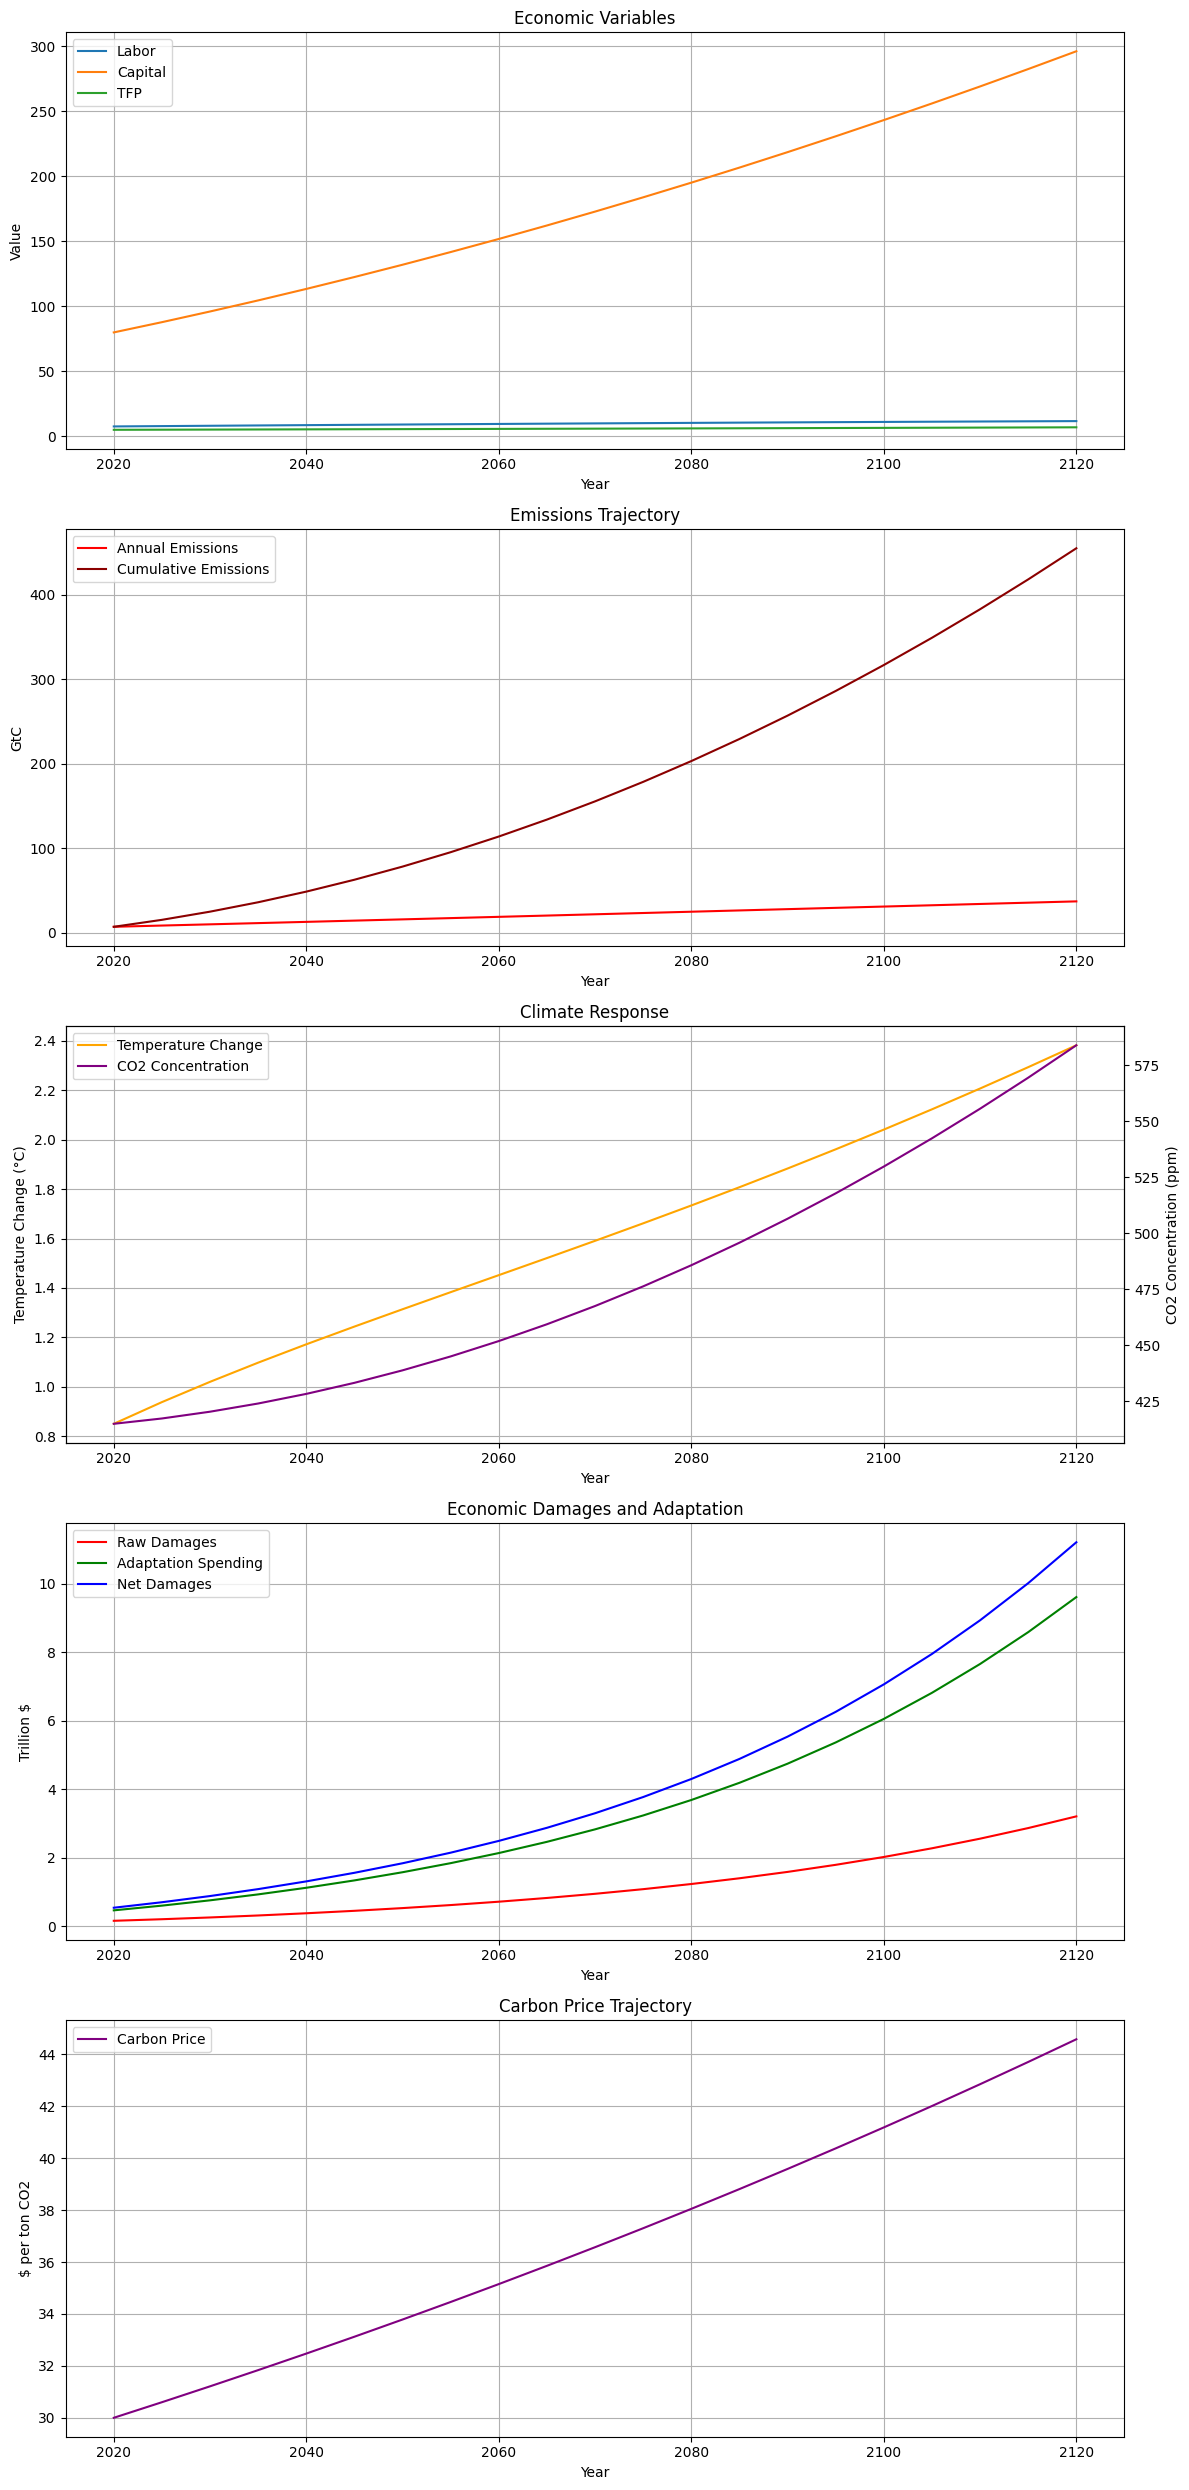

In [3]:
model=DICEModel()
df_economy=model.run_economy()

## Optimal adaptation costs

In [4]:
# Create test instance
model = DICEModel()

# Test cases
temperatures = [1.0, 2.0, 3.0, 4.0]  # Different temperature increases
output = 100  # Example economic output (trillion $)

print("Testing adaptation spending:")
print("Temperature (°C) | Raw Damages (%) | Optimal Adaptation ($T)")
print("-" * 55)

for temp in temperatures:
    raw_damage_fraction = model.calculate_damages(temp)
    adaptation_spending = model.calculate_optimal_adaptation(temp, output)
    print(f"{temp:13.1f} | {raw_damage_fraction*100:13.2f} | {adaptation_spending:20.2f}")

Testing adaptation spending:
Temperature (°C) | Raw Damages (%) | Optimal Adaptation ($T)
-------------------------------------------------------
          1.0 |          0.27 |                 0.80
          2.0 |          1.06 |                 3.17
          3.0 |          2.35 |                 7.04
          4.0 |          4.10 |                12.29


## Carbon price scenarios

In [5]:
model=DICEModel()
model.test_carbon_price_scenarios().round(3)

,Cumulative_Emissions,Final_Temperature,Carbon_Price_Final
Low,648.480,2.733,24.404
Medium,210.497,1.954,74.297
High,186.944,1.938,180.611
